### Downloading the data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tkkreddy","key":"92c7848435e1a8409fed486d3f9d5597"}'}

In [ ]:
!mkdir ~/.kaggle

# Copy the keggle json to folder created
!cp kaggle.json ~/.kaggle/

# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# List all the datasets in Keggle
! kaggle datasets list

ref                                                                     title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                                     Online Food Dataset                                  3KB  2024-03-02 18:50:30          15044        309  0.9411765        
sukhmandeepsinghbrar/car-price-prediction-dataset                       Car Price Prediction Dataset                       141KB  2024-03-28 08:27:39            673         26  1.0              
prishasawhney/imdb-dataset-top-2000-movies                              IMDB Dataset (Top 2000 movies)                      75KB  2024-03-27 18:51:36            647         22  1.0              
syedanwarafridi/vehicle-s

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:07<00:00, 112MB/s] 
100% 812M/812M [00:07<00:00, 114MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

#Transferring pictures to test, validation, and training folders and intially considering 1000 for train, 500 for test and 500 for validation

In [ ]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_1000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 1000),
    "validation": (1000, 1500),
    "test": (1500, 2000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training=1000, Validation=500 and Test=500

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#Displaying the shapes of the data and labels yielded by the Dataset

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#Fitting the model using a Dataset

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
63/63 [==============================] - 132s 2s/step - loss: 0.6883 - accuracy: 0.5360 - val_loss: 0.6779 - val_accuracy: 0.5910
Epoch 2/10
63/63 [==============================] - 127s 2s/step - loss: 0.6660 - accuracy: 0.5765 - val_loss: 0.6520 - val_accuracy: 0.5930
Epoch 3/10
63/63 [==============================] - 125s 2s/step - loss: 0.6315 - accuracy: 0.6375 - val_loss: 0.6558 - val_accuracy: 0.6070
Epoch 4/10
63/63 [==============================] - 135s 2s/step - loss: 0.6192 - accuracy: 0.6510 - val_loss: 0.6382 - val_accuracy: 0.6280
Epoch 5/10
63/63 [==============================] - 130s 2s/step - loss: 0.5937 - accuracy: 0.6810 - val_loss: 0.6377 - val_accuracy: 0.6270
Epoch 6/10
63/63 [==============================] - 125s 2s/step - loss: 0.5715 - accuracy: 0.6955 - val_loss: 0.5972 - val_accuracy: 0.6820
Epoch 7/10
63/63 [==============================] - 129s 2s/step - loss: 0.5344 - accuracy: 0.7305 - val_loss: 0.5886 - val_accuracy: 0.6980
Epoch 8/10
63

#Ploting curves of loss and accuracy during training

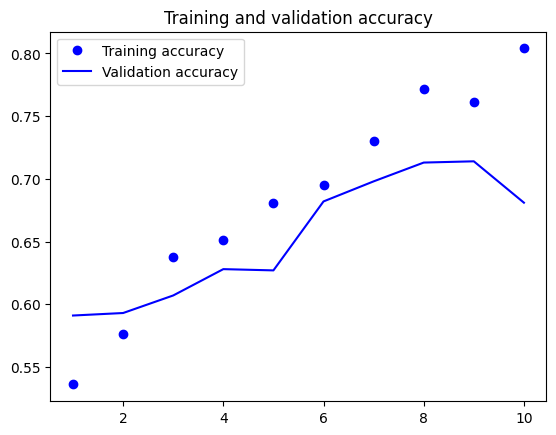

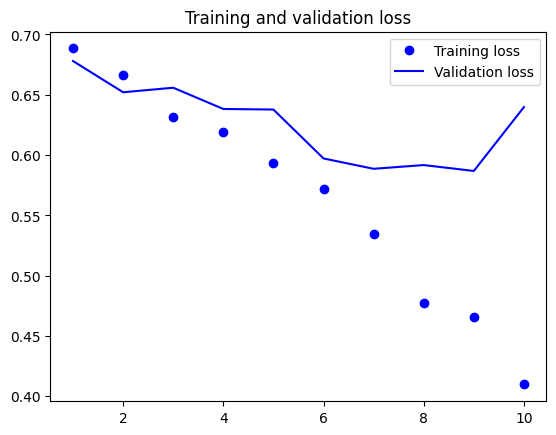

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 16s 501ms/step - loss: 0.6272 - accuracy: 0.6990
Test accuracy: 0.699


#Transferring pictures to test, validation, and training folders and intially considering 1500 for train, 500 for test and 500 for validation

In [ ]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_2000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 1500),
    "validation": (1500, 2000),
    "test": (2000, 2500)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training=1500, Validation=500, Test=500

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a Dataset**

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
94/94 [==============================] - 179s 2s/step - loss: 0.6882 - accuracy: 0.5303 - val_loss: 0.6732 - val_accuracy: 0.5640
Epoch 2/10
94/94 [==============================] - 188s 2s/step - loss: 0.6534 - accuracy: 0.6030 - val_loss: 0.6660 - val_accuracy: 0.5800
Epoch 3/10
94/94 [==============================] - 183s 2s/step - loss: 0.6169 - accuracy: 0.6573 - val_loss: 0.6159 - val_accuracy: 0.6560
Epoch 4/10
94/94 [==============================] - 179s 2s/step - loss: 0.5602 - accuracy: 0.7160 - val_loss: 0.6048 - val_accuracy: 0.6890
Epoch 5/10
94/94 [==============================] - 181s 2s/step - loss: 0.5349 - accuracy: 0.7330 - val_loss: 0.5934 - val_accuracy: 0.7100
Epoch 6/10
94/94 [==============================] - 181s 2s/step - loss: 0.4838 - accuracy: 0.7637 - val_loss: 0.5440 - val_accuracy: 0.7450
Epoch 7/10
94/94 [==============================] - 177s 2s/step - loss: 0.4243 - accuracy: 0.8063 - val_loss: 0.5652 - val_accuracy: 0.7180
Epoch 8/10
94

**Plotting curves of loss and accuracy during training**

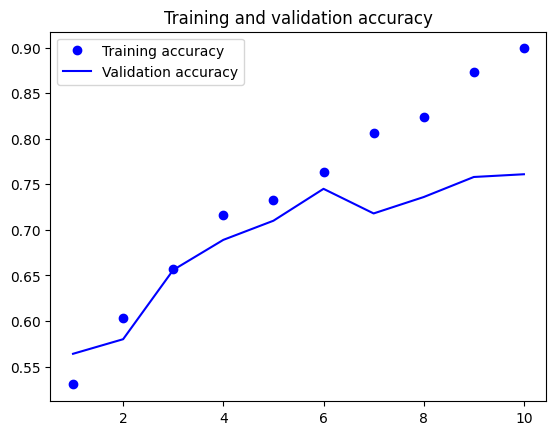

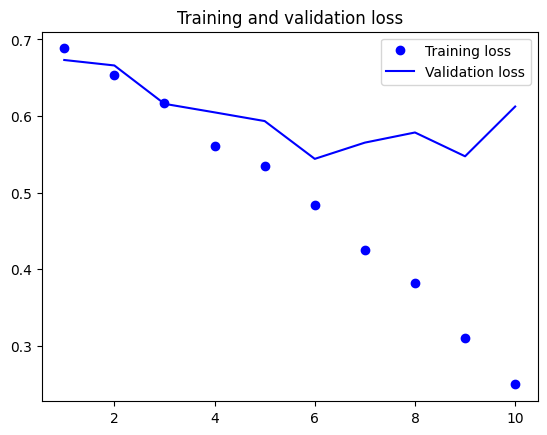

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 17s 497ms/step - loss: 0.5159 - accuracy: 0.7490
Test accuracy: 0.749


#Transferring pictures to test, validation, and training folders and considering 2000 for train, 500 for test and 500 for validation

In [ ]:
import os
import shutil
from pathlib import Path

original_dir = Path("train")
new_base_dir = Path("cats_vs_dogs_small_3000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        subset_dir = new_base_dir / subset_name / category
        os.makedirs(subset_dir, exist_ok=True)  # Create the directory if it doesn't exist
        file_names = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for file_name in file_names:
            source_path = original_dir / file_name
            destination_path = subset_dir / file_name
            shutil.copyfile(src=source_path, dst=destination_path)

# Define the ranges for each subset
subset_ranges = {
    "train": (0, 2000),
    "validation": (2000, 2500),
    "test": (2500, 3000)
}

# Generate the subsets
for subset_name, (start, end) in subset_ranges.items():
    make_subset(subset_name, start, end)


### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Data preprocessing: Rescale the input values to the range [0, 1]
x = layers.Rescaling(1./255)(inputs)

# Define the convolutional layers
conv_filters = [32, 64, 128, 256, 256]
for filters in conv_filters:
    x = layers.Conv2D(filters=filters, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

# Flatten the output for fully connected layers
x = layers.Flatten()(x)

# Define the output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Data preprocessing

#Training = 2000; Validation = 500; Test = 500

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')


**Fitting the model using a `Dataset`**

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.x",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/10
125/125 [==============================] - 238s 2s/step - loss: 0.2470 - val_loss: 0.2294
Epoch 2/10
125/125 [==============================] - 230s 2s/step - loss: 0.2275 - val_loss: 0.2279
Epoch 3/10
125/125 [==============================] - 243s 2s/step - loss: 0.2134 - val_loss: 0.2024
Epoch 4/10
125/125 [==============================] - 241s 2s/step - loss: 0.1879 - val_loss: 0.1898
Epoch 5/10
125/125 [==============================] - 241s 2s/step - loss: 0.1784 - val_loss: 0.1751
Epoch 6/10
125/125 [==============================] - 235s 2s/step - loss: 0.1588 - val_loss: 0.1636
Epoch 7/10
125/125 [==============================] - 234s 2s/step - loss: 0.1493 - val_loss: 0.1546
Epoch 8/10
125/125 [==============================] - 237s 2s/step - loss: 0.1243 - val_loss: 0.1472
Epoch 9/10
125/125 [==============================] - 229s 2s/step - loss: 0.1068 - val_loss: 0.1502
Epoch 10/10
125/125 [==============================] - 236s 2s/step - loss: 0.0803 - val_lo

# Evaluating the model on the test set

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.x")
test_result = test_model.evaluate(test_dataset)
print(f"Test result: {test_result}")

32/32 [==============================] - 16s 475ms/step - loss: 0.1704
Test result: 0.17039887607097626


# **Using data augmentation**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# Showing some randomly enhanced training pictures

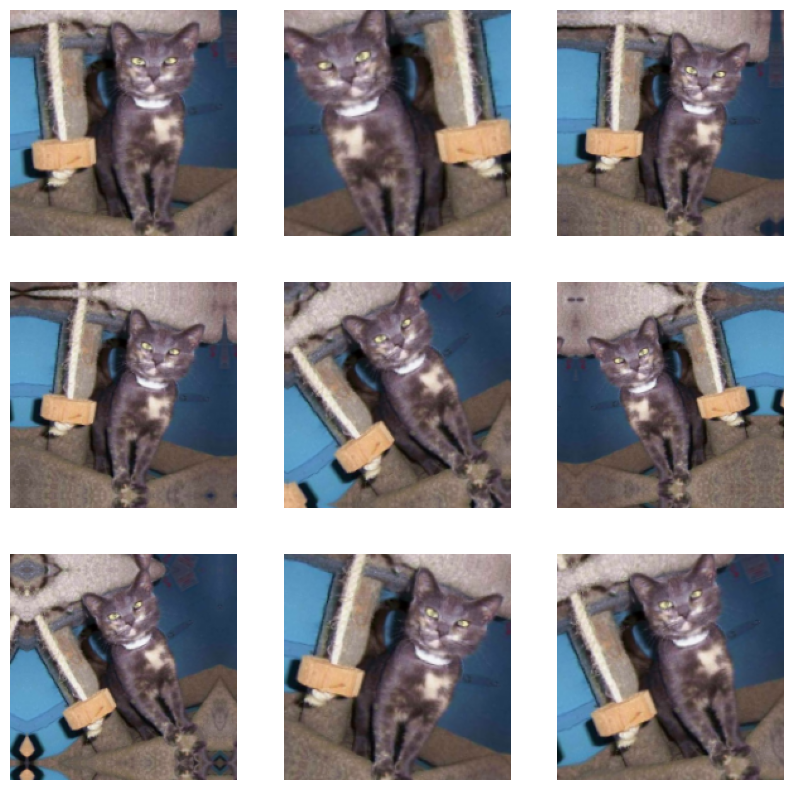

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# **Defining a new convnet that includes image augmentation and dropout**

In [50]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# **Training the regularized convnet**

In [51]:
#Have run with data augmentation for training set of 1000, 1500 and 2000
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
125/125 [==============================] - 280s 2s/step - loss: 0.6935 - accuracy: 0.5148 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/10
125/125 [==============================] - 255s 2s/step - loss: 0.6935 - accuracy: 0.5092 - val_loss: 0.6923 - val_accuracy: 0.5260
Epoch 3/10
125/125 [==============================] - 250s 2s/step - loss: 0.6927 - accuracy: 0.5132 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 4/10
125/125 [==============================] - 251s 2s/step - loss: 0.6889 - accuracy: 0.5232 - val_loss: 0.6927 - val_accuracy: 0.5040
Epoch 5/10
125/125 [==============================] - 245s 2s/step - loss: 0.6886 - accuracy: 0.5265 - val_loss: 0.6911 - val_accuracy: 0.5110
Epoch 6/10
125/125 [==============================] - 253s 2s/step - loss: 0.6839 - accuracy: 0.5487 - val_loss: 0.6690 - val_accuracy: 0.5650
Epoch 7/10
125/125 [==============================] - 246s 2s/step - loss: 0.6618 - accuracy: 0.6060 - val_loss: 0.6519 - val_accuracy: 0.6040

# **Evaluating the model on the test set**

In [52]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 16s 505ms/step - loss: 0.6171 - accuracy: 0.6740
Test accuracy: 0.674


# Using a pretrained model


In [53]:
import keras
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [54]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# Feature extraction without data augmentation

In [55]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


#Defining and training the classifier

In [56]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
125/125 [==============================] - 5s 33ms/step - loss: 7.6021 - accuracy: 0.9495 - val_loss: 6.3078 - val_accuracy: 0.9680
Epoch 2/10
125/125 [==============================] - 4s 34ms/step - loss: 2.2741 - accuracy: 0.9833 - val_loss: 4.6449 - val_accuracy: 0.9670
Epoch 3/10
125/125 [==============================] - 7s 56ms/step - loss: 1.7487 - accuracy: 0.9872 - val_loss: 5.9568 - val_accuracy: 0.9720
Epoch 4/10
125/125 [==============================] - 5s 39ms/step - loss: 1.3038 - accuracy: 0.9920 - val_loss: 6.6135 - val_accuracy: 0.9690
Epoch 5/10
125/125 [==============================] - 4s 28ms/step - loss: 0.3456 - accuracy: 0.9962 - val_loss: 6.6200 - val_accuracy: 0.9660
Epoch 6/10
125/125 [==============================] - 4s 29ms/step - loss: 0.2725 - accuracy: 0.9965 - val_loss: 8.4777 - val_accuracy: 0.9650
Epoch 7/10
125/125 [==============================] - 5s 39ms/step - loss: 0.2159 - accuracy: 0.9980 - val_loss: 9.0539 - val_accuracy: 0.9610

# Graphical representation

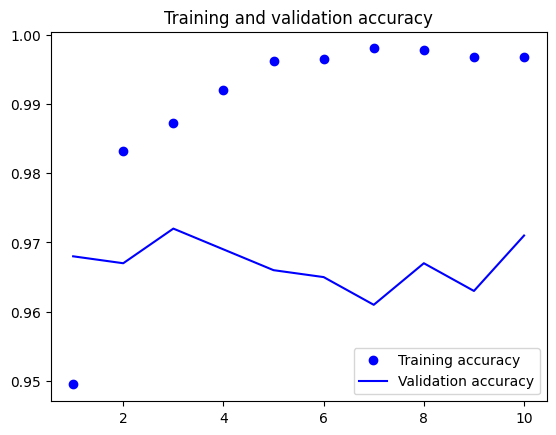

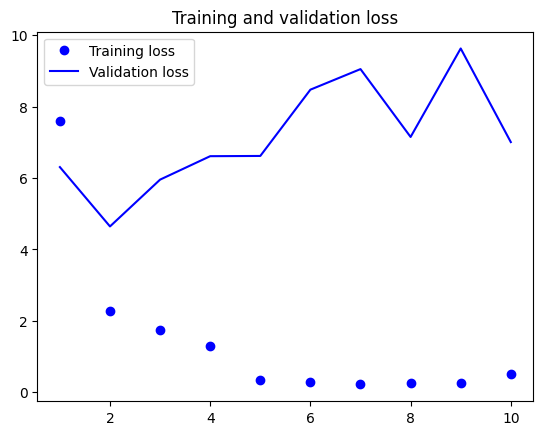

In [57]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [58]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Result: {test_result}, Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 7ms/step - loss: 7.7509 - accuracy: 0.9670
Test Loss: 7.750890731811523
Test Accuracy: 0.9670000076293945


# Changing optimizer to rmsprop

In [59]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
125/125 [==============================] - 4s 32ms/step - loss: 14.9413 - accuracy: 0.9442 - val_loss: 9.3992 - val_accuracy: 0.9570
Epoch 2/10
125/125 [==============================] - 5s 40ms/step - loss: 3.3533 - accuracy: 0.9787 - val_loss: 6.2846 - val_accuracy: 0.9640
Epoch 3/10
125/125 [==============================] - 3s 22ms/step - loss: 2.5306 - accuracy: 0.9827 - val_loss: 6.4315 - val_accuracy: 0.9680
Epoch 4/10
125/125 [==============================] - 3s 28ms/step - loss: 1.2582 - accuracy: 0.9900 - val_loss: 5.8712 - val_accuracy: 0.9680
Epoch 5/10
125/125 [==============================] - 3s 28ms/step - loss: 0.6809 - accuracy: 0.9945 - val_loss: 5.6173 - val_accuracy: 0.9710
Epoch 6/10
125/125 [==============================] - 4s 34ms/step - loss: 0.7295 - accuracy: 0.9942 - val_loss: 7.3066 - val_accuracy: 0.9660
Epoch 7/10
125/125 [==============================] - 4s 30ms/step - loss: 0.4415 - accuracy: 0.9960 - val_loss: 7.2918 - val_accuracy: 0.972

In [60]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Result: {test_result}, Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 9ms/step - loss: 7.2070 - accuracy: 0.9710
Test Loss: 7.206967353820801
Test Accuracy: 0.9710000157356262


# Feature extraction together with data augmentation

In [61]:
import keras
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

# Printing the trainable weights list both before and after the freezer

In [62]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [63]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


# incorporating a classifier and a data augmentation stage into the convolutional base

In [64]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [65]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
125/125 [==============================] - 1336s 11s/step - loss: 7.6514 - accuracy: 0.9218 - val_loss: 5.6531 - val_accuracy: 0.9650
Epoch 2/10
125/125 [==============================] - 1317s 11s/step - loss: 5.2633 - accuracy: 0.9580 - val_loss: 8.4934 - val_accuracy: 0.9450
Epoch 3/10
125/125 [==============================] - 1324s 11s/step - loss: 3.7899 - accuracy: 0.9595 - val_loss: 2.8522 - val_accuracy: 0.9750
Epoch 4/10
125/125 [==============================] - 1319s 11s/step - loss: 2.4517 - accuracy: 0.9695 - val_loss: 3.3107 - val_accuracy: 0.9710
Epoch 5/10
125/125 [==============================] - 1317s 11s/step - loss: 1.4550 - accuracy: 0.9745 - val_loss: 2.4828 - val_accuracy: 0.9750
Epoch 6/10
125/125 [==============================] - 1315s 11s/step - loss: 1.5956 - accuracy: 0.9703 - val_loss: 1.8010 - val_accuracy: 0.9800
Epoch 7/10
125/125 [==============================] - 1312s 11s/step - loss: 1.3109 - accuracy: 0.9743 - val_loss: 1.3363 - val_ac

# Graphical representation

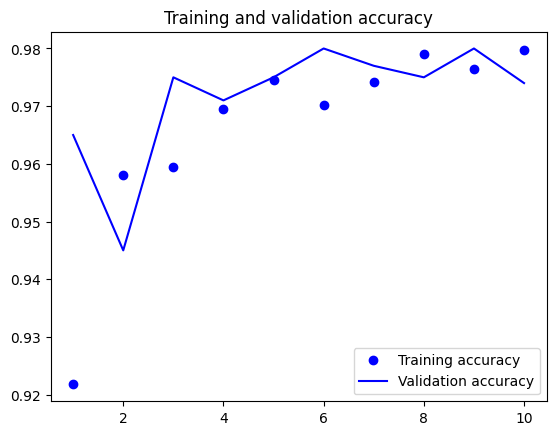

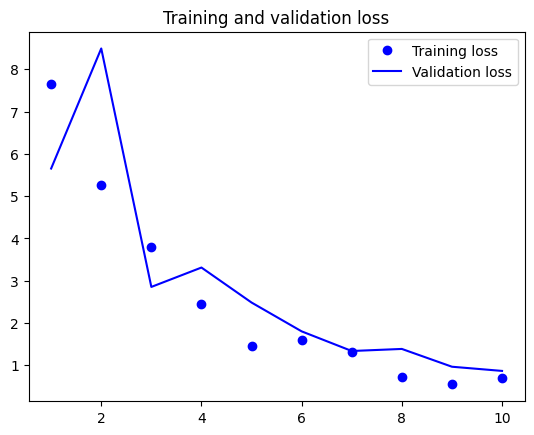

In [66]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evaluating the model on the test set

In [67]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 263s 8s/step - loss: 0.8400 - accuracy: 0.9740
Test accuracy: 0.974


In [68]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [69]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
125/125 [==============================] - 1322s 11s/step - loss: 11.5619 - accuracy: 0.9193 - val_loss: 23.8361 - val_accuracy: 0.9050
Epoch 2/10
125/125 [==============================] - 1320s 11s/step - loss: 5.8442 - accuracy: 0.9507 - val_loss: 5.8467 - val_accuracy: 0.9660
Epoch 3/10
125/125 [==============================] - 1321s 11s/step - loss: 5.3909 - accuracy: 0.9523 - val_loss: 4.7416 - val_accuracy: 0.9690
Epoch 4/10
125/125 [==============================] - 1318s 11s/step - loss: 3.8213 - accuracy: 0.9628 - val_loss: 4.4215 - val_accuracy: 0.9690
Epoch 5/10
125/125 [==============================] - 1319s 11s/step - loss: 2.9135 - accuracy: 0.9655 - val_loss: 3.4060 - val_accuracy: 0.9710
Epoch 6/10
125/125 [==============================] - 1312s 11s/step - loss: 3.0113 - accuracy: 0.9672 - val_loss: 5.5180 - val_accuracy: 0.9640
Epoch 7/10
125/125 [==============================] - 1319s 11s/step - loss: 2.0805 - accuracy: 0.9688 - val_loss: 2.5856 - val_

#Evaluating model on test set

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 264s 8s/step - loss: 2.2153 - accuracy: 0.9760
